In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
loss = np.load("trained_models/loss_lsst_u.npy")
val = np.load("trained_models/valloss_lsst_u.npy")

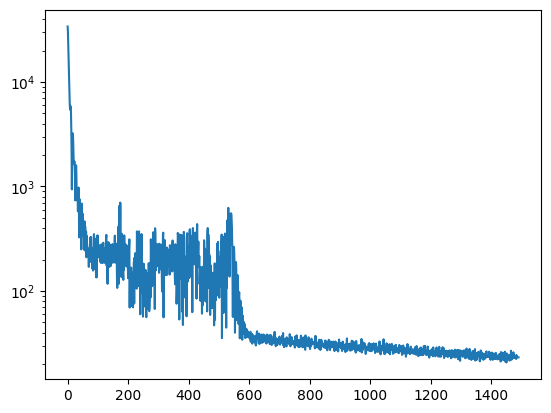

In [8]:
plt.plot(loss)
plt.yscale("log")

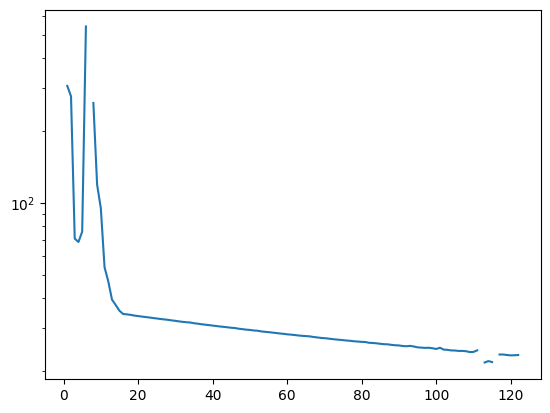

In [10]:
plt.plot(val)
plt.yscale("log")